In [1]:
# Training
!python main_vicreg.py --batch-size 512 --mlp '512-512-512'

In [ ]:

# Installing dependencies
!pip install torch torchvision matplotlib seaborn scikit-learn pandas


In [2]:
# Cell 1: Import necessary modules
import torch
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from custom_resnet import custom_Resnet,Resnet_block
import pandas as pd

In [3]:
# Cell 2: Load pretrained model
ssl_model_state_dict = torch.load("exp/resnet_backbone_2.pth")

In [4]:
# Cell 3: Define data transformations and load the dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
# Load the CIFAR-10 dataset with 1% labeled data
trainset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)


Files already downloaded and verified


In [5]:
def get_data_loader(dataset, batch_size, percent_per_class):

    # Get the list of classes
    classes = dataset.classes

    # Create a dictionary to hold the indices of the images for each class
    indices = {}
    for c in classes:
        indices[c] = []

    # Populate the dictionary with the indices of the images for each class
    for i in range(len(dataset)):
        _, label = dataset[i]
        indices[classes[label]].append(i)

    # Create a list of indices to use for each class based on the percentage
    subset_indices = []
    for c in classes:
        num_images = len(indices[c])
        num_subset_images = int(num_images * percent_per_class)
        subset_indices.extend(indices[c][:num_subset_images])

    # Create a subset sampler using the subset indices
    
    
    subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(subset_indices)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=subset_sampler)
    return data_loader

cifar10_1pct_train_loader = get_data_loader(dataset=trainset, batch_size=32, percent_per_class=0.01)
cifar10_10pct_train_loader = get_data_loader(dataset=trainset, batch_size=256, percent_per_class=0.1)

In [6]:
# Create dataloaders
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

Files already downloaded and verified


In [8]:
# Define model architecture

def get_model_arch(is_backbone_trained, is_backbone_frozen):
    head = nn.Sequential(
        nn.Linear(in_features=128, out_features=10),
    )

    backbone = custom_Resnet(Resnet_block,32,[13,13,13])
    if is_backbone_trained:
        backbone.load_state_dict(ssl_model_state_dict)

    model = nn.Sequential(
        backbone,
        head
    )
    
    if is_backbone_frozen:
        for param in backbone.parameters():
            param.requires_grad = False
        
    # Define the optimizer and the loss function
    
    optimizer = torch.optim.Adam(head.parameters(), lr=1e-3) if is_backbone_frozen else torch.optim.SGD(model.parameters(), lr=1e-2,momentum=0.9,weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, criterion

In [10]:
# Training loop 
device =torch.device("cuda")
def train(train_data_loader, is_backbone_frozen, is_backbone_trained):
    print(f'Training for is_backbone_frozen: {is_backbone_frozen} and is_backbone_trained: {is_backbone_trained}')
    model, optimizer, criterion = get_model_arch(is_backbone_trained, is_backbone_frozen)
    num_epochs= 20 if is_backbone_frozen else 50
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / len(train_data_loader)))
    return model

In [26]:
models = {
    'frozen_backbone': {
        'trained_backbone': {
            '1pct': train(train_data_loader=cifar10_1pct_train_loader, is_backbone_frozen=True, is_backbone_trained=True),
            '10pct': train(train_data_loader=cifar10_10pct_train_loader, is_backbone_frozen=True, is_backbone_trained=True),
            'flags': {'is_backbone_frozen':True, 'is_backbone_trained': True}
        },
        'untrained_backbone': {
            '1pct': train(train_data_loader=cifar10_1pct_train_loader, is_backbone_frozen=True, is_backbone_trained=False),
            '10pct': train(train_data_loader=cifar10_10pct_train_loader, is_backbone_frozen=True, is_backbone_trained=False),
            'flags': {'is_backbone_frozen':True, 'is_backbone_trained': False}
        }
    },
    'unfrozen_backbone': {
        'trained_backbone': {
            '1pct': train(train_data_loader=cifar10_1pct_train_loader, is_backbone_frozen=False, is_backbone_trained=True),
            '10pct': train(train_data_loader=cifar10_10pct_train_loader, is_backbone_frozen=False, is_backbone_trained=True),
            'flags': {'is_backbone_frozen':False, 'is_backbone_trained': True}
        },
        'untrained_backbone': {
            '1pct': train(train_data_loader=cifar10_1pct_train_loader, is_backbone_frozen=False, is_backbone_trained=False),
            '10pct': train(train_data_loader=cifar10_10pct_train_loader, is_backbone_frozen=False, is_backbone_trained=False),
            'flags': {'is_backbone_frozen':False, 'is_backbone_trained': False}
        }
    }
}

Training for is_backbone_frozen: True and is_backbone_trained: True
[1,    16] loss: 3.467
[2,    16] loss: 2.591
[3,    16] loss: 2.452
[4,    16] loss: 2.285
[5,    16] loss: 2.241
[6,    16] loss: 2.143
[7,    16] loss: 2.111
[8,    16] loss: 2.065
[9,    16] loss: 2.046
[10,    16] loss: 2.036
[11,    16] loss: 1.978
[12,    16] loss: 1.985
[13,    16] loss: 1.976
[14,    16] loss: 1.978
[15,    16] loss: 1.993
[16,    16] loss: 1.940
[17,    16] loss: 2.003
[18,    16] loss: 1.945
[19,    16] loss: 1.942
[20,    16] loss: 1.885
Training for is_backbone_frozen: True and is_backbone_trained: True
[1,    20] loss: 2.965
[2,    20] loss: 2.385
[3,    20] loss: 2.177
[4,    20] loss: 2.060
[5,    20] loss: 1.986
[6,    20] loss: 1.938
[7,    20] loss: 1.915
[8,    20] loss: 1.928
[9,    20] loss: 1.894
[10,    20] loss: 1.871
[11,    20] loss: 1.873
[12,    20] loss: 1.870
[13,    20] loss: 1.875
[14,    20] loss: 1.849
[15,    20] loss: 1.852
[16,    20] loss: 1.836
[17,    20] loss: 

In [27]:
# Evaluation of the model
# Evaluation functions
def evaluate_top_3(model, test_loader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.topk(k=3, dim=1)
            labels = labels.view(-1, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

def evaluate(model, dataloader, device):
    # Set model to evaluation mode
    model.eval()

    # Initialize variables to track accuracy and loss
    total_correct = 0
    total_loss = 0
    total_samples = 0

    # Disable gradient computation (speeds up inference)
    with torch.no_grad():
        # Iterate over batches in the dataloader
        for images, labels in dataloader:
            # Move data to the specified device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass to get logits
            logits = model(images)

            # Compute cross-entropy loss
            loss = F.cross_entropy(logits, labels, reduction='sum')

            # Compute predictions and accuracy
            predictions = torch.argmax(logits, dim=1)
            total_correct += torch.sum(predictions == labels)
            total_loss += loss.item()
            total_samples += images.shape[0]

    # Compute average accuracy and loss
    avg_accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples

    return avg_accuracy.item(), avg_loss

def plot_confusion_matrix(model, dataloader, device):
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(10,10))
    class_names = dataloader.dataset.classes
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def model_evaluation(model):
    accuracy_1, loss_1 = evaluate(model,testloader,device)
    accuracy_top3_1 = evaluate_top_3(model,testloader,device)

    print(f'Top-1 Accuracy: {accuracy_1*100}%')
    print(f'Top-3 Accuracy: {accuracy_top3_1}%')
    print(f'Loss: {loss_1}')

In [28]:
flags = [(True, True), (True, False), (False, True), (False, False)]
for backbone_status, training_dict in models.items():
    for training_status, data_dict in training_dict.items():
        print(f"For is_backbone_frozen: {data_dict['flags']['is_backbone_frozen']} and is_backbone_trained: {data_dict['flags']['is_backbone_trained']}:")
        print("Evaluating model on 1% data:")
        model_evaluation(data_dict['1pct'])
        print("Evaluating model on 10% data:")
        model_evaluation(data_dict['10pct'])
        print('-----------------------------')

For is_backbone_frozen: True and is_backbone_trained: True:
Evaluating model on 1% data:
Top-1 Accuracy: 41.62999987602234%
Top-3 Accuracy: 73.58%
Loss: 1.6812709199905396
Evaluating model on 10% data:
Top-1 Accuracy: 43.449997901916504%
Top-3 Accuracy: 76.03999999999999%
Loss: 1.604470898246765
-----------------------------
For is_backbone_frozen: True and is_backbone_trained: False:
Evaluating model on 1% data:
Top-1 Accuracy: 26.269999146461487%
Top-3 Accuracy: 59.61%
Loss: 2.0407925256729125
Evaluating model on 10% data:
Top-1 Accuracy: 28.09000015258789%
Top-3 Accuracy: 62.28%
Loss: 1.9992845993041992
-----------------------------
For is_backbone_frozen: False and is_backbone_trained: True:
Evaluating model on 1% data:
Top-1 Accuracy: 38.2999986410141%
Top-3 Accuracy: 75.36%
Loss: 2.78705161819458
Evaluating model on 10% data:
Top-1 Accuracy: 67.03000068664551%
Top-3 Accuracy: 89.86%
Loss: 1.179547594165802
-----------------------------
For is_backbone_frozen: False and is_backbon

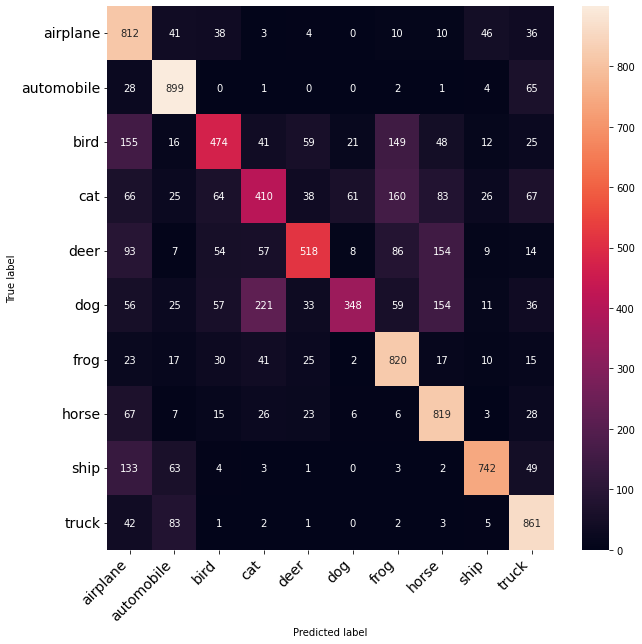

In [29]:
plot_confusion_matrix(models['unfrozen_backbone']['trained_backbone']['10pct'], testloader, device)